In [1]:
import collections
import itertools
import json
import pathlib

import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
device = torch.device('cuda')

In [3]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [4]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [5]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [6]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

In [7]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [8]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file', 'title'])

def standard_experiment(experiment_dir, epoch, title=None):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
        title=title,
    )

In [23]:
PLOT_DIR = 'output/plots/inat21mini-res18-ep20'
experiments = {
    'flat': standard_experiment(
        title='Flat',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
#     'flat-ls': standard_experiment(
#         title='Flat+LS',
#         experiment_dir='',
#         epoch=20),
    'focal': standard_experiment(
        title='Multilabel (focal)',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
#     'focal': standard_experiment(
#         title='Multilabel (focal)'
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/multilabel_focal-0.25-2-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),

    'cond-softmax': standard_experiment(
        title='Cond softmax',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/hier_softmax-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'cond-sigmoid': standard_experiment(
        title='Cond sigmoid',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/cond_multilabel-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'levelwise': standard_experiment(
        title='Level-wise softmax',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/levelwise_softmax-sum-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),

    'share_random_cut': standard_experiment(
        title='Deep RTC',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),

    'descendant': standard_experiment(
        title='Soft-max-descendant',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/descendant_softmax-bal-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'cousin': standard_experiment(
        title='... + cousin loss',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/descendant_softmax_complement-bal-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),

#     'margin_incorrect': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'margin_incorrect_x2': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-2-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
    'margin_incorrect_x5': standard_experiment(
        title='Soft-max-margin',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-5-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
#     'margin_incorrect_x10': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-10-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'margin_incorrect_x20': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-20-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),

#     'margin_dist': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'margin_dist_fn': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-depth_deficient-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
}

In [24]:
markers = {
    'leaf': 'o',
    'majority': '^',
    # 'exclusive': 'd',
}

colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [25]:
def apply_model(net, pred_fn, min_threshold):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), None):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [26]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
#     specificity_seq = [np.flip(seq) for seq in specificity_seq]
#     metric_values_seq = {field: np.flip(seq) for field, seq in metric_values_seq.items()}
#     pareto_scores, pareto_totals = metrics.operating_curve(specificity_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [27]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [28]:
MIN_THRESHOLD = 0.1  # Values less than 0.5 may increase runtime significantly.

for name, experiment in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(experiment.config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(experiment.model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

cached: flat


apply:   2% (6/391); T=0.840 f=1.19; mean T=0.840 f=1.19; elapsed 0:00:05; remaining 0:05:23 of 0:05:28
apply:   3% (13/391); T=0.738 f=1.36; mean T=0.785 f=1.27; elapsed 0:00:10; remaining 0:04:57 of 0:05:07
apply:   6% (25/391); T=0.451 f=2.22; mean T=0.624 f=1.60; elapsed 0:00:16; remaining 0:03:49 of 0:04:04
apply:   9% (37/391); T=0.441 f=2.27; mean T=0.565 f=1.77; elapsed 0:00:21; remaining 0:03:20 of 0:03:41
apply:  13% (49/391); T=0.438 f=2.29; mean T=0.534 f=1.87; elapsed 0:00:26; remaining 0:03:03 of 0:03:29
apply:  16% (61/391); T=0.432 f=2.32; mean T=0.514 f=1.95; elapsed 0:00:31; remaining 0:02:50 of 0:03:21
apply:  19% (73/391); T=0.430 f=2.33; mean T=0.500 f=2.00; elapsed 0:00:36; remaining 0:02:39 of 0:03:15
apply:  22% (85/391); T=0.435 f=2.30; mean T=0.491 f=2.04; elapsed 0:00:42; remaining 0:02:30 of 0:03:12
apply:  25% (97/391); T=0.434 f=2.31; mean T=0.484 f=2.07; elapsed 0:00:47; remaining 0:02:22 of 0:03:09
apply:  28% (109/391); T=0.430 f=2.32; mean T=0.478 f=2.

apply:  35% (138/391); T=0.442 f=2.26; mean T=0.457 f=2.19; elapsed 0:01:03; remaining 0:01:56 of 0:02:59
apply:  38% (150/391); T=0.428 f=2.34; mean T=0.454 f=2.20; elapsed 0:01:08; remaining 0:01:50 of 0:02:58
apply:  41% (162/391); T=0.438 f=2.28; mean T=0.453 f=2.21; elapsed 0:01:13; remaining 0:01:44 of 0:02:57
apply:  45% (174/391); T=0.421 f=2.38; mean T=0.451 f=2.22; elapsed 0:01:18; remaining 0:01:38 of 0:02:56
apply:  48% (186/391); T=0.422 f=2.37; mean T=0.449 f=2.23; elapsed 0:01:24; remaining 0:01:32 of 0:02:56
apply:  51% (198/391); T=0.419 f=2.39; mean T=0.447 f=2.24; elapsed 0:01:29; remaining 0:01:26 of 0:02:55
apply:  54% (210/391); T=0.423 f=2.36; mean T=0.446 f=2.24; elapsed 0:01:34; remaining 0:01:21 of 0:02:54
apply:  57% (222/391); T=0.418 f=2.39; mean T=0.444 f=2.25; elapsed 0:01:39; remaining 0:01:15 of 0:02:54
apply:  60% (234/391); T=0.421 f=2.38; mean T=0.443 f=2.26; elapsed 0:01:44; remaining 0:01:10 of 0:02:53
apply:  63% (246/391); T=0.427 f=2.34; mean T=

cached: share_random_cut


apply:   2% (6/391); T=0.859 f=1.16; mean T=0.859 f=1.16; elapsed 0:00:05; remaining 0:05:31 of 0:05:36
apply:   4% (17/391); T=0.460 f=2.17; mean T=0.601 f=1.66; elapsed 0:00:10; remaining 0:03:45 of 0:03:55
apply:   7% (29/391); T=0.452 f=2.21; mean T=0.539 f=1.85; elapsed 0:00:16; remaining 0:03:15 of 0:03:31
apply:  10% (40/391); T=0.456 f=2.19; mean T=0.517 f=1.94; elapsed 0:00:21; remaining 0:03:01 of 0:03:22
apply:  13% (51/391); T=0.459 f=2.18; mean T=0.504 f=1.98; elapsed 0:00:26; remaining 0:02:51 of 0:03:17
apply:  16% (62/391); T=0.455 f=2.20; mean T=0.495 f=2.02; elapsed 0:00:31; remaining 0:02:43 of 0:03:14
apply:  19% (73/391); T=0.458 f=2.18; mean T=0.490 f=2.04; elapsed 0:00:36; remaining 0:02:36 of 0:03:12
apply:  21% (84/391); T=0.456 f=2.19; mean T=0.485 f=2.06; elapsed 0:00:41; remaining 0:02:29 of 0:03:10
apply:  24% (95/391); T=0.461 f=2.17; mean T=0.483 f=2.07; elapsed 0:00:46; remaining 0:02:23 of 0:03:09
apply:  27% (106/391); T=0.474 f=2.11; mean T=0.482 f=2.

apply:  23% (91/391); T=0.439 f=2.28; mean T=0.466 f=2.15; elapsed 0:00:42; remaining 0:02:20 of 0:03:02
apply:  26% (103/391); T=0.443 f=2.26; mean T=0.463 f=2.16; elapsed 0:00:48; remaining 0:02:13 of 0:03:01
apply:  29% (115/391); T=0.440 f=2.28; mean T=0.461 f=2.17; elapsed 0:00:53; remaining 0:02:07 of 0:03:00
apply:  32% (127/391); T=0.431 f=2.32; mean T=0.458 f=2.18; elapsed 0:00:58; remaining 0:02:01 of 0:02:59
apply:  36% (139/391); T=0.434 f=2.31; mean T=0.456 f=2.19; elapsed 0:01:03; remaining 0:01:55 of 0:02:58
apply:  38% (150/391); T=0.455 f=2.20; mean T=0.456 f=2.19; elapsed 0:01:08; remaining 0:01:50 of 0:02:58
apply:  41% (161/391); T=0.465 f=2.15; mean T=0.456 f=2.19; elapsed 0:01:13; remaining 0:01:45 of 0:02:58
apply:  44% (173/391); T=0.440 f=2.27; mean T=0.455 f=2.20; elapsed 0:01:19; remaining 0:01:39 of 0:02:58
apply:  47% (184/391); T=0.455 f=2.20; mean T=0.455 f=2.20; elapsed 0:01:24; remaining 0:01:34 of 0:02:58
apply:  50% (195/391); T=0.476 f=2.10; mean T=0

In [29]:
INTEGRALS = {
    'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    key: {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in experiments if name in results
    } for key, (x, y) in INTEGRALS.items()
}

pd.DataFrame(auc).style.format('{:.1%}'.format)

,AC(depth),AC(info),AP(depth),AP(info),AC(exact)
flat,73.8%,64.7%,75.8%,66.9%,44.3%
focal,65.3%,52.6%,70.3%,57.4%,25.4%
cond-softmax,68.5%,57.1%,71.5%,60.2%,31.2%
cond-sigmoid,67.8%,56.0%,70.7%,59.0%,29.3%
levelwise,72.6%,62.8%,74.9%,65.2%,38.7%
share_random_cut,57.1%,50.0%,68.6%,57.6%,32.1%
descendant,72.2%,63.1%,74.7%,65.5%,38.5%
cousin,72.7%,63.9%,74.9%,65.9%,39.5%
margin_incorrect_x5,74.4%,66.0%,76.0%,67.6%,48.0%


In [30]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [0.95, 0.9]

recalls = {
    (c, y): {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            c)
        for name in results
    } for c in CORRECT for y in INTERCEPTS
}

pd.DataFrame(recalls).style.format('{:.1%}'.format)

In [31]:
def plot_metrics(x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for name in experiments:
        if name not in results:
            continue
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=experiments[name].title or name)
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], linestyle='--')
        for method in ['leaf', 'majority']:  # pred_metrics.items():
            plt.plot(pred_metrics[method][x], pred_metrics[method][y],
                     color=colors[name], marker=markers[method],
                     markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
        # plt.ylim(np.clip(plt.ylim(), 0, 1))
        # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    plt.legend()

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')

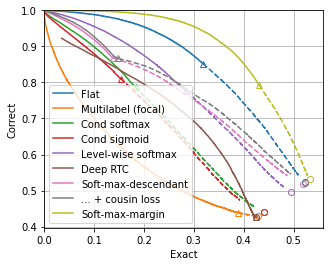

In [32]:
plot_metrics('exact', 'correct', save=True)

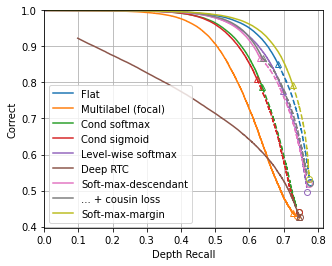

In [33]:
plot_metrics('depth_recall', 'correct', save=True)

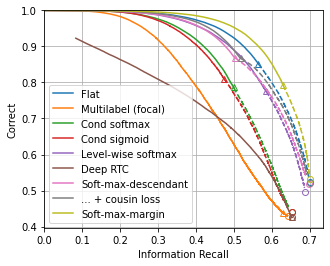

In [34]:
plot_metrics('info_recall', 'correct', save=True)

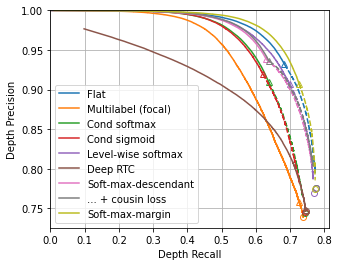

In [35]:
plot_metrics('depth_recall', 'depth_precision', save=True)

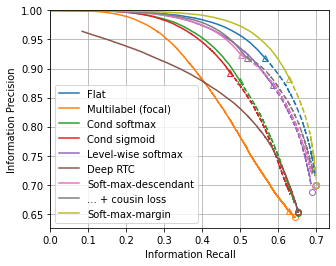

In [36]:
plot_metrics('info_recall', 'info_precision', save=True)